In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from matplotlib.transforms import Affine2D
from scipy.integrate import quad as quad
%matplotlib notebook

from astropy import constants as const
from astropy.table import Table
from astropy.io import fits
import sys
sys.path.insert(0, "/scratch/ierez/IGMCosmo/VoidFinder/python/")
import voidfinder
#from voidfinder.voidfinder_functions import xyz_to_radecz #THERE IS NO SUCH FUNCTION

In [2]:
#copy pasted from github

RtoD = 180./np.pi
DtoR = np.pi/180.
dec_offset = -90
def to_array(table):
    '''Convert table to numpy array'''

    array = np.array([table['x'], table['y'], table['z']])
    array = array.T

    return array

def xyz_to_radecz(sphere_table):
    '''
    Calculate the ra, dec coordinates for the centers of each sphere
    '''

    r = np.linalg.norm(to_array(sphere_table), axis=1)
    sphere_table['r'] = r.T
    sphere_table['ra'] = np.arctan(sphere_table['y']/sphere_table['x'])*RtoD
    sphere_table['dec'] = np.arcsin(sphere_table['z']/sphere_table['r'])*RtoD

    # Adjust ra value as necessary
    boolean = np.logical_and(sphere_table['y'] != 0, sphere_table['x'] < 0)
    sphere_table['ra'][boolean] += 180.

    return sphere_table

# Data files

### Galaxies

In [3]:
data_directory = '/scratch/sbenzvi_lab/boss/dr16/delta_fields/'

dr7_filename = data_directory + 'deltafields_RAadded90.fits'

# Downsampled SDSS DR7 (to match SDSS LOWZ)
#downDR7_filename = data_directory + 'kias1033_5_LOWZ.txt'

quasars_filename='/scratch/sbenzvi_lab/boss/dr16/delta_fields/quasars.fits'

### Voids

In [4]:
void_directory = '/scratch/ierez/IGMCosmo/VoidFinder/outputs/'

# Original DR7 voids
void_filename = void_directory + 'delta_runsdeltafields_added90_fixed._comoving_holes_noMagCut.txt'

# Downsampled SDSS DR7 voids
#downDR7void_filename = void_directory + 'kias1033_5_LOWZ_comoving_holes.txt'

# Import data

### Galaxies

In [5]:
# Original SDSS DR7
#dr7_galaxies = Table.read(dr7_filename, 
#                          format='ascii.commented_header', 
#                          include_names=['ra', 'dec', 'redshift', 'delta'])

dr7_galaxies=fits.open(dr7_filename)  

dr7_galaxies=Table(dr7_galaxies[1].data)
dr7_galaxies
dr7_galaxies['z'].name='redshift'

quasars=fits.open(quasars_filename) 
quasars=Table(quasars[1].data)
quasars
# Downsampled SDSS DR7
#dr7LOWZ_galaxies = Table.read(downDR7_filename, 
#                              format='ascii.commented_header', 
#                              include_names=['ra', 'dec', 'redshift', 'Rgal', 'rabsmag'])

ra,dec,z
float64,float64,float64
-34.90196644835447,-1.159330826846483,3.774
-34.692674572422334,-1.0531637172445856,3.446
-34.60865459248191,-0.8345530857219153,2.75148963928223
-34.472523569472685,-0.9748963978803513,2.704
-34.444164549902894,-1.142452301903663,2.341
-34.42495345854309,-0.7253719805422782,2.618
-34.38626621702588,-0.6943935181822574,2.116
-34.383540267834576,-0.7240672011037926,2.20196866989136
-34.35570880937678,-1.0621194224534276,2.226


##### Reduce original DR7 to magnitude-limited survey

In [6]:
#mag_cut = dr7_galaxies['rabsmag'] <= -20
#z_cut = dr7_galaxies['redshift'] < 0.1026

#vollim_dr7_galaxies = dr7_galaxies[np.logical_and(mag_cut, z_cut)]
vollim_dr7_galaxies = dr7_galaxies

### Voids

In [7]:
# Original DR7 voids
dr7_voids = Table.read(void_filename, format='ascii.commented_header')

# Downsampled SDSS DR7 voids
#dr7LOWZ_voids = Table.read(downDR7void_filename, format='ascii.commented_header')

##### Convert x,y,z to ra,dec,z for voids

In [8]:
dr7_voids = xyz_to_radecz(dr7_voids)
#dr7LOWZ_voids = xyz_to_radecz(dr7LOWZ_voids)

# Convert redshift to comoving distance

Going to plot $comoving distance$ in Mpch-1
At these high redshifts, cz is not meaningful. So plot for comoving distance instead.

In [9]:
c = const.c.to('km/s').value
#z to comoving
#voidfinder.distance.z_to_comoving_dist

Omega_M = 0.3147
c = const.c.to('km/s').value
def Distance(z,omega_m = Omega_M,h = 1):
    dist = np.ones(len(z))
    H0 = 100*h
    for i,redshift in enumerate(z):
        a_start = 1/(1+redshift)
        I = quad(f,a_start,1,args=omega_m)
        dist[i] = I[0]*(c/H0)
    return dist

def f(a,omega_m = Omega_M):
     return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))

quasars['r']= Distance(quasars['z'],Omega_M,1)
#Continue with voids['r']

dr7_galaxies['r']= Distance(dr7_galaxies['redshift'],Omega_M,1)
#dr7LOWZ_galaxies['cz'] = c*dr7LOWZ_galaxies['redshift']

## Check inside the tables

In [10]:
dr7_galaxies

ra,dec,redshift,delta,r
float64,float64,float64,float64,float64
55.09803355164553,-1.159330826846483,3.08463316655781,-2.6700565094875603,4441.089182834704
55.09803355164553,-1.159330826846483,3.0855737963916345,-1.4396249644115322,4441.6885026673845
55.09803355164553,-1.159330826846483,3.0865146428384156,-0.45740696573626016,4442.287759909381
55.09803355164553,-1.159330826846483,3.087455705948044,4.137706831117744,4442.886954562955
55.09803355164553,-1.159330826846483,3.0883969857704057,1.155314062862347,4443.4860866303525
55.09803355164553,-1.159330826846483,3.089338482355416,0.6930459621176261,4444.085156113841
55.09803355164553,-1.159330826846483,3.0902801957529826,0.7347019382798468,4444.684163015671
55.09803355164553,-1.159330826846483,3.091222126013043,-1.2423201316433645,4445.283107338119
55.09803355164553,-1.159330826846483,3.092164273185528,0.5741067276945806,4445.881989083444


In [11]:
dr7_voids

x,y,z,radius,flag,r,ra,dec
float64,float64,float64,float64,int64,float64,float64,float64
-2515.42124464839,2885.946757228773,-16.42206829896108,45.4095805765128,0,3828.355052488593,131.07574572430192,-0.24577607800015427
-2781.999251278872,3174.6785755458645,-12.387618442482179,44.833192621207964,1,4221.167770325743,131.2283739970088,-0.16814287238730227
-2718.7345299884423,3106.7495724128507,-10.825927230149468,41.01574251985375,2,4128.380742002765,131.18935785296907,-0.15024792752096416
-2718.556406466175,3107.7353498611233,-10.46833009713479,40.23975267737992,2,4129.004423084304,131.17848942078973,-0.14526304993112013
-2771.853255654397,3181.019731295694,4.83119397228613,39.79723217561291,1,4219.251158939179,131.06799982726363,0.06560573776744526
-2714.653226097867,3106.0945243861015,-9.606747978887265,38.36129040889744,2,4125.1978888280755,131.15269088493744,-0.13343035325613983
-2829.8881978977583,3242.510918653365,-35.81959808089134,38.2328217845694,3,4303.885141798511,131.11269714671744,-0.4768564726010077
-2645.3879289997963,3036.442370314083,4.539654145278671,38.08638684643787,4,4027.1677605478762,131.0628019818055,0.06458709781289475
-2826.5451819598443,3256.960392199935,-13.686408444153635,37.53097096659718,3,4312.462867062818,130.95299961397558,-0.18183919053338957


In [12]:
quasars

ra,dec,z,r
float64,float64,float64,float64
-34.90196644835447,-1.159330826846483,3.774,4832.81253150792
-34.692674572422334,-1.0531637172445856,3.446,4657.527770830647
-34.60865459248191,-0.8345530857219153,2.75148963928223,4215.34429893826
-34.472523569472685,-0.9748963978803513,2.704,4180.800516204877
-34.444164549902894,-1.142452301903663,2.341,3894.00482503552
-34.42495345854309,-0.7253719805422782,2.618,4116.594594846443
-34.38626621702588,-0.6943935181822574,2.116,3692.996778095992
-34.383540267834576,-0.7240672011037926,2.20196866989136,3772.142622767125
-34.35570880937678,-1.0621194224534276,2.226,3793.734586416724


In [13]:
max(dr7_voids['ra'])

134.91715949387938

In [14]:
max(quasars['ra'])

44.99658812997919

In [15]:
max(dr7_galaxies['ra'])

134.9965881299792

In [16]:
dr7_voids['ra']=dr7_voids['ra']-90
dr7_galaxies['ra']=dr7_galaxies['ra']-90

# Function to set up axes

Following function from declination_slice.ipynb

In [17]:
def setup_axes3(fig, rect, ra0, ra1, cz0, cz1):
    
    # rotate a bit for better orientation
    #tr_rotate = Affine2D().translate(-90, 0) #already fixed ra
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180, 1)

    #tr = tr_rotate + tr_scale + mpl.projections.PolarAxes.PolarTransform()
    tr = tr_scale + mpl.projections.PolarAxes.PolarTransform()
    
    grid_locator1 = angle_helper.LocatorHMS(4)
    tick_formatter1 = angle_helper.FormatterHMS()
    
    grid_locator2 = MaxNLocator(3)
    
    grid_helper = floating_axes.GridHelperCurveLinear(tr, extremes=(ra0, ra1, cz0, cz1),
                                                      grid_locator1=grid_locator1,
                                                      grid_locator2=grid_locator2,
                                                      tick_formatter1=tick_formatter1,
                                                      tick_formatter2=None)

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)
    
    # adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    
    ax1.axis['right'].set_axis_direction('top')
    
    ax1.axis['bottom'].set_visible(False)
    
    ax1.axis['top'].set_axis_direction("bottom")
    ax1.axis['top'].toggle(ticklabels=True, label=True)
    ax1.axis['top'].major_ticklabels.set_axis_direction("top")
    ax1.axis['top'].label.set_axis_direction("top")
    
    #ax1.axis['left'].major_ticklabels.set_axis_direction('right')
    ax1.axis["left"].label.set_text("Comoving Distance [Mpc/h]")
    
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  

    return ax1, aux_ax

# Wedge plot

In [18]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get different slices
d,s = -1.25, 2.5 #s=2.5

# slice center, can use this for analysis since the slice thickness is very small
slice_ = d + 0.5*s

### Remove galaxies outside declination range

In [19]:
dr7_dec_cut = np.logical_and(dr7_galaxies['dec'] > d, 
                             dr7_galaxies['dec'] <= d + s)

#dr7LOWZ_dec_cut = np.logical_and(dr7LOWZ_galaxies['dec'] > d, 
#                                 dr7LOWZ_galaxies['dec'] <= d + s)
#
vollim_dr7_dec_cut = np.logical_and(vollim_dr7_galaxies['dec'] > d, 
                                    vollim_dr7_galaxies['dec'] <= d + s)
#
dr7_dec_slice = dr7_galaxies[dr7_dec_cut]
#dr7LOWZ_dec_slice = dr7LOWZ_galaxies[dr7LOWZ_dec_cut]
vollim_dr7_dec_slice = vollim_dr7_galaxies[vollim_dr7_dec_cut]

quasars_dec_cut = np.logical_and(quasars['dec'] > d, 
                             quasars['dec'] <= d + s)

quasars_slice = quasars[quasars_dec_cut]

### Remove galaxies outside distance range

In [20]:
cz_min, cz_max = min(dr7_voids['r']), max(dr7_voids['r']) #32700

dr7_dist_boolean = np.logical_and(dr7_dec_slice['r'] > cz_min, 
                                  dr7_dec_slice['r'] <= cz_max)

#dr7LOWZ_dist_boolean = np.logical_and(dr7LOWZ_dec_slice['cz'] > cz_min, 
#                                      dr7LOWZ_dec_slice['cz'] <= cz_max)
#
#vollim_dr7_dist_boolean = np.logical_and(vollim_dr7_dec_slice['cz'] > cz_min, 
#                                         vollim_dr7_dec_slice['cz'] <= cz_max)
#
dr7_sample = dr7_dec_slice[dr7_dist_boolean]
#dr7LOWZ_sample = dr7LOWZ_dec_slice[dr7LOWZ_dist_boolean]
#vollim_dr7_sample = vollim_dr7_dec_slice[vollim_dr7_dist_boolean]


### Voids that intersect the slice

In [21]:
dr7_dec_intersect_cut = np.sin(np.abs(slice_ - dr7_voids['dec'])*np.pi/180)*dr7_voids['r'] <= dr7_voids['radius']
#dr7LOWZ_dec_intersect_cut = np.sin(np.abs(slice_ - dr7LOWZ_voids['dec'])*np.pi/180)*dr7LOWZ_voids['r'] <= dr7LOWZ_voids['radius']

dr7_void_sample = dr7_voids[dr7_dec_intersect_cut]
#dr7LOWZ_void_sample = dr7LOWZ_voids[dr7LOWZ_dec_intersect_cut]

# Radius of void at intersection
dr7_void_sample['radius_intersect'] = np.sqrt(dr7_void_sample['radius']**2 
                                              - (np.sin(np.abs(slice_ - dr7_void_sample['dec'])*np.pi/180)*dr7_void_sample['r'])**2)

#dr7LOWZ_void_sample['radius_intersect'] = np.sqrt(dr7LOWZ_void_sample['radius']**2 
#                                                  - (np.sin(np.abs(slice_ - dr7LOWZ_void_sample['dec'])*np.pi/180)*dr7LOWZ_void_sample['r'])**2)

In [22]:
min(quasars['ra'])

-42.99625309050879

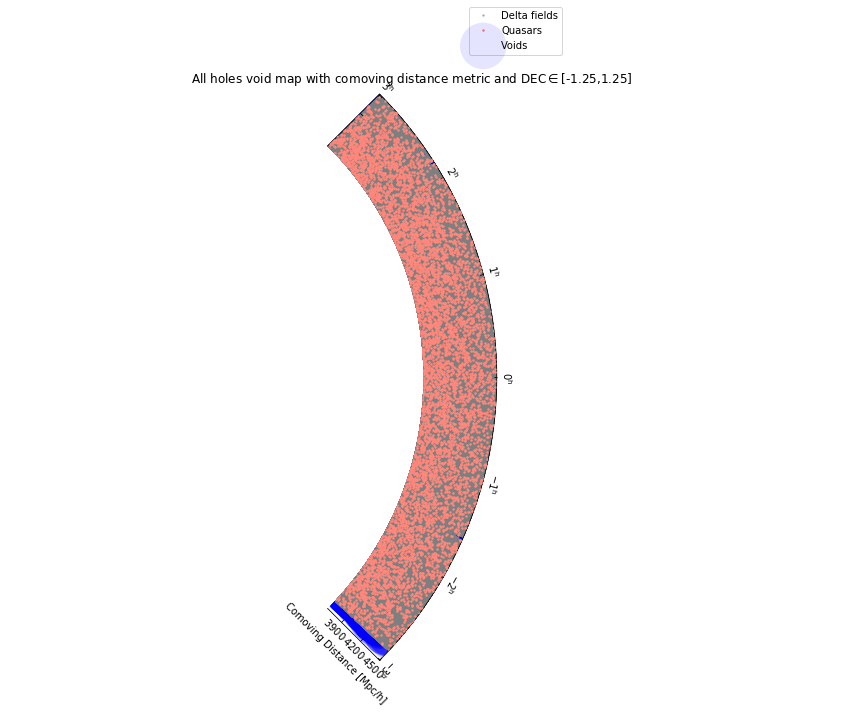

In [23]:
fig = plt.figure(figsize=(15,10))

# Range of ra to use in plot
ra_min, ra_max = -45, 45

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Original DR7 galaxies
aux_ax.plot(dr7_sample['ra'], dr7_sample['r'], 
            '.', c='grey', alpha=0.5, ms=3, zorder=2, label='Delta fields')

# Volume-limited DR7 galaxies
#aux_ax.plot(vollim_dr7_sample['ra'], vollim_dr7_sample['cz'], 
#            '.', c='g', zorder=2, label='Volume-limited DR7')

# Downsampled DR7 galaxies
#aux_ax.plot(dr7LOWZ_sample['ra'], dr7LOWZ_sample['cz'], 
#            '.', c='m', zorder=3, label='DR7 LOWZ')

# Original voids
aux_ax.scatter(dr7_void_sample['ra'], dr7_void_sample['r'], 
               s=dr7_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='b', alpha=0.1, 
               zorder=1, label='Voids')

aux_ax.plot(quasars['ra'], 
            quasars['r'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=3, label='Quasars')
# Downsampled voids
#aux_ax.scatter(dr7LOWZ_void_sample['ra'], dr7LOWZ_void_sample['r']*100, 
#               s=dr7LOWZ_void_sample['radius_intersect']*100, 
#               edgecolors='none', facecolors='tab:orange', alpha=0.1, 
#               zorder=5, label='DR7 LOWZ voids')

ax.legend(bbox_to_anchor=(1.1, 1.05),loc='lower center')

mpl.rc('font', size=10)
plt.title('All holes void map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
plt.tight_layout();

In [24]:
dr7_sample

ra,dec,redshift,delta,r
float64,float64,float64,float64,float64
-34.90196644835447,-1.159330826846483,3.08463316655781,-2.6700565094875603,4441.089182834704
-34.90196644835447,-1.159330826846483,3.0855737963916345,-1.4396249644115322,4441.6885026673845
-34.90196644835447,-1.159330826846483,3.0865146428384156,-0.45740696573626016,4442.287759909381
-34.90196644835447,-1.159330826846483,3.087455705948044,4.137706831117744,4442.886954562955
-34.90196644835447,-1.159330826846483,3.0883969857704057,1.155314062862347,4443.4860866303525
-34.90196644835447,-1.159330826846483,3.089338482355416,0.6930459621176261,4444.085156113841
-34.90196644835447,-1.159330826846483,3.0902801957529826,0.7347019382798468,4444.684163015671
-34.90196644835447,-1.159330826846483,3.091222126013043,-1.2423201316433645,4445.283107338119
-34.90196644835447,-1.159330826846483,3.092164273185528,0.5741067276945806,4445.881989083444


In [25]:
dr7_void_sample

x,y,z,radius,flag,r,ra,dec,radius_intersect
float64,float64,float64,float64,int64,float64,float64,float64,float64
-2515.42124464839,2885.946757228773,-16.42206829896108,45.4095805765128,0,3828.355052488593,41.075745724301925,-0.24577607800015427,42.33610375222389
-2781.999251278872,3174.6785755458645,-12.387618442482179,44.833192621207964,1,4221.167770325743,41.22837399700879,-0.16814287238730227,43.08784132367055
-2718.7345299884423,3106.7495724128507,-10.825927230149468,41.01574251985375,2,4128.380742002765,41.18935785296907,-0.15024792752096416,39.56122386962324
-2718.556406466175,3107.7353498611233,-10.46833009713479,40.23975267737992,2,4129.004423084304,41.17848942078973,-0.14526304993112013,38.85423735597092
-2771.853255654397,3181.019731295694,4.83119397228613,39.79723217561291,1,4219.251158939179,41.067999827263634,0.06560573776744526,39.50290183824203
-2714.653226097867,3106.0945243861015,-9.606747978887265,38.36129040889744,2,4125.1978888280755,41.15269088493744,-0.13343035325613983,37.13891483479171
-2829.8881978977583,3242.510918653365,-35.81959808089134,38.2328217845694,3,4303.885141798511,41.11269714671744,-0.4768564726010077,13.368061001284
-2645.3879289997963,3036.442370314083,4.539654145278671,38.08638684643787,4,4027.1677605478762,41.06280198180551,0.06458709781289475,37.81487013408574
-2826.5451819598443,3256.960392199935,-13.686408444153635,37.53097096659718,3,4312.462867062818,40.95299961397558,-0.18183919053338957,34.94647343574685


## Thinner slice

In [26]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get different slices
d,s = 0, 0.05 #s=2.5

# slice center, can use this for analysis since the slice thickness is very small
slice_ = d + 0.5*s

In [27]:
dr7_dec_cut = np.logical_and(dr7_galaxies['dec'] > d, 
                             dr7_galaxies['dec'] <= d + s)

#dr7LOWZ_dec_cut = np.logical_and(dr7LOWZ_galaxies['dec'] > d, 
#                                 dr7LOWZ_galaxies['dec'] <= d + s)
#
vollim_dr7_dec_cut = np.logical_and(vollim_dr7_galaxies['dec'] > d, 
                                    vollim_dr7_galaxies['dec'] <= d + s)
#
dr7_dec_slice = dr7_galaxies[dr7_dec_cut]
#dr7LOWZ_dec_slice = dr7LOWZ_galaxies[dr7LOWZ_dec_cut]
vollim_dr7_dec_slice = vollim_dr7_galaxies[vollim_dr7_dec_cut]

quasars_dec_cut = np.logical_and(quasars['dec'] > d, 
                             quasars['dec'] <= d + s)

quasars_slice = quasars[quasars_dec_cut]

In [28]:
cz_min, cz_max = min(dr7_voids['r']), max(dr7_voids['r']) #32700

dr7_dist_boolean = np.logical_and(dr7_dec_slice['r'] > cz_min, 
                                  dr7_dec_slice['r'] <= cz_max)

#dr7LOWZ_dist_boolean = np.logical_and(dr7LOWZ_dec_slice['cz'] > cz_min, 
#                                      dr7LOWZ_dec_slice['cz'] <= cz_max)
#
#vollim_dr7_dist_boolean = np.logical_and(vollim_dr7_dec_slice['cz'] > cz_min, 
#                                         vollim_dr7_dec_slice['cz'] <= cz_max)
#
dr7_sample = dr7_dec_slice[dr7_dist_boolean]
#dr7LOWZ_sample = dr7LOWZ_dec_slice[dr7LOWZ_dist_boolean]
#vollim_dr7_sample = vollim_dr7_dec_slice[vollim_dr7_dist_boolean]


In [29]:
dr7_dec_intersect_cut = np.sin(np.abs(slice_ - dr7_voids['dec'])*np.pi/180)*dr7_voids['r'] <= dr7_voids['radius']
#dr7LOWZ_dec_intersect_cut = np.sin(np.abs(slice_ - dr7LOWZ_voids['dec'])*np.pi/180)*dr7LOWZ_voids['r'] <= dr7LOWZ_voids['radius']

dr7_void_sample = dr7_voids[dr7_dec_intersect_cut]
#dr7LOWZ_void_sample = dr7LOWZ_voids[dr7LOWZ_dec_intersect_cut]

# Radius of void at intersection
dr7_void_sample['radius_intersect'] = np.sqrt(dr7_void_sample['radius']**2 
                                              - (np.sin(np.abs(slice_ - dr7_void_sample['dec'])*np.pi/180)*dr7_void_sample['r'])**2)

#dr7LOWZ_void_sample['radius_intersect'] = np.sqrt(dr7LOWZ_void_sample['radius']**2 
#                                                  - (np.sin(np.abs(slice_ - dr7LOWZ_void_sample['dec'])*np.pi/180)*dr7LOWZ_void_sample['r'])**2)

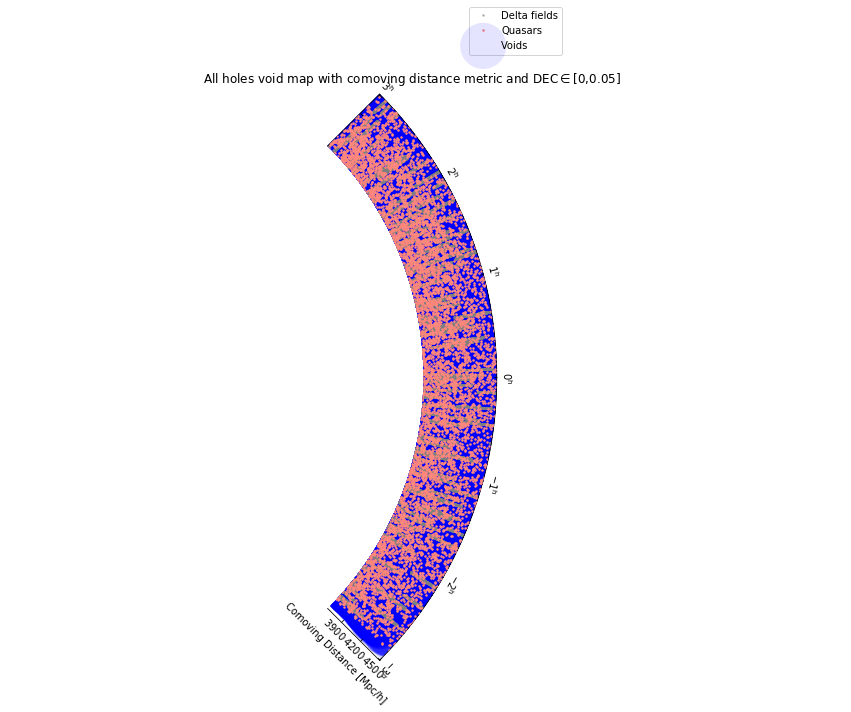

In [30]:
fig = plt.figure(figsize=(15,10))

# Range of ra to use in plot
ra_min, ra_max = -45, 45

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Original DR7 galaxies
aux_ax.plot(dr7_sample['ra'], dr7_sample['r'], 
            '.', c='grey', alpha=0.5, ms=3, zorder=2, label='Delta fields')

# Volume-limited DR7 galaxies
#aux_ax.plot(vollim_dr7_sample['ra'], vollim_dr7_sample['cz'], 
#            '.', c='g', zorder=2, label='Volume-limited DR7')

# Downsampled DR7 galaxies
#aux_ax.plot(dr7LOWZ_sample['ra'], dr7LOWZ_sample['cz'], 
#            '.', c='m', zorder=3, label='DR7 LOWZ')

# Original voids
aux_ax.scatter(dr7_void_sample['ra'], dr7_void_sample['r'], 
               s=dr7_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='b', alpha=0.1, 
               zorder=1, label='Voids')

aux_ax.plot(quasars['ra'], 
            quasars['r'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=3, label='Quasars')
# Downsampled voids
#aux_ax.scatter(dr7LOWZ_void_sample['ra'], dr7LOWZ_void_sample['r']*100, 
#               s=dr7LOWZ_void_sample['radius_intersect']*100, 
#               edgecolors='none', facecolors='tab:orange', alpha=0.1, 
#               zorder=5, label='DR7 LOWZ voids')

ax.legend(bbox_to_anchor=(1.1, 1.05),loc='lower center')

mpl.rc('font', size=10)
plt.title('All holes void map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
plt.tight_layout();

<Figure size 1080x576 with 0 Axes>

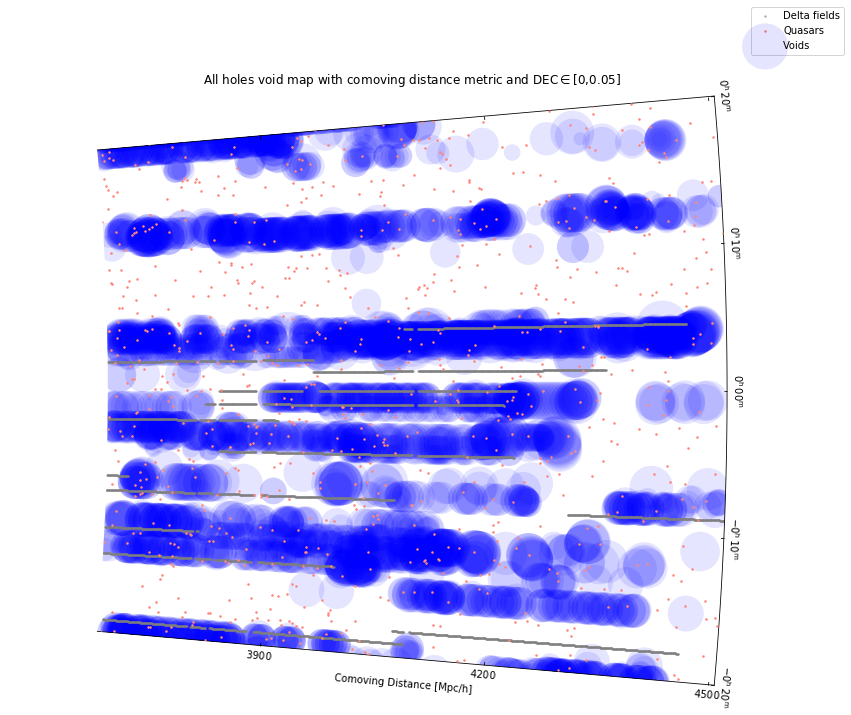

In [31]:
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -5, 5

fig = plt.figure(figsize=(15,10))

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Original DR7 galaxies
aux_ax.plot(dr7_sample['ra'], dr7_sample['r'], 
            '.', c='grey', alpha=0.5, ms=3, zorder=2, label='Delta fields')

# Volume-limited DR7 galaxies
#aux_ax.plot(vollim_dr7_sample['ra'], vollim_dr7_sample['cz'], 
#            '.', c='g', zorder=2, label='Volume-limited DR7')

# Downsampled DR7 galaxies
#aux_ax.plot(dr7LOWZ_sample['ra'], dr7LOWZ_sample['cz'], 
#            '.', c='m', zorder=3, label='DR7 LOWZ')

# Original voids
aux_ax.scatter(dr7_void_sample['ra'], dr7_void_sample['r'], 
               s=dr7_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='b', alpha=0.1, 
               zorder=1, label='Voids')

aux_ax.plot(quasars['ra'], 
            quasars['r'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=3, label='Quasars')
# Downsampled voids
#aux_ax.scatter(dr7LOWZ_void_sample['ra'], dr7LOWZ_void_sample['r']*100, 
#               s=dr7LOWZ_void_sample['radius_intersect']*100, 
#               edgecolors='none', facecolors='tab:orange', alpha=0.1, 
#               zorder=5, label='DR7 LOWZ voids')

ax.legend(bbox_to_anchor=(1.1, 1.05),loc='lower center')

mpl.rc('font', size=10)
plt.title('All holes void map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
plt.tight_layout();